# Importing libraries and datasets

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from google.colab import files
import matplotlib.pyplot as plt
from keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom

In [ ]:
# upload kaggle API token
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d yuulind/imdb-clean
!kaggle datasets download -d jangedoo/utkface-new

In [ ]:
!unzip imdb-clean.zip -d imdb_clean/
!unzip utkface-new.zip -d UTKFace

# Functions and Configurations

In [6]:
gender_mapping = {
    'F':0,
    'M':1
}

gender_mapping_fn = {
    0: 'Female',
    1: 'Male'
}

# data augmentation
augment = keras.Sequential([
    RandomFlip(mode='horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

# returns images with their corresponding labels and bounding boxes
def get_img_paths_labels_bboxes(df):
    img_paths, labels, bboxes = [], [], []
    for index, row in df.iterrows():
        img_path = os.path.join(path_to_100directories, row['filename'])
        if os.path.exists(img_path):
            img_paths.append(img_path)
            labels.append(gender_mapping[row['gender']])
            bboxes.append([row['x_min'], row['y_min'], row['x_max'], row['y_max']])
    return img_paths, labels, bboxes

# crops, resizes and normalizes images
def preprocess_image(img_path, bbox=None):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)

    if bbox is not None:
      bbox = tf.cast(bbox, tf.int32)
      img = tf.image.crop_to_bounding_box(img, offset_height=bbox[1], offset_width=bbox[0],
                                          target_height=bbox[3] - bbox[1], target_width=bbox[2] - bbox[0])

    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0
    return img

# crops, resizes, normalizes, and augments images
def preprocess_and_augment(img_path, bbox):
    img = preprocess_image(img_path, bbox)
    img = augment(img)
    return img

# displays images with their labels
def display_images_with_labels(dataset, num_samples=5):
    plt.figure(figsize=(15, 15))
    for i, (image, label) in enumerate(dataset.unbatch().take(num_samples)):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.numpy())
        plt.title(f"gender: {gender_mapping_fn[label.numpy()]}")
        plt.axis("off")

UTKFace

In [7]:
# extracts the label from the filename
def extract_label(filename, index):
    try:
        parts = filename.split('_')
        label = int(parts[index])
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None
    return label

# extracts age and gender
def extract_age(filename):
    return extract_label(filename, 0)

def extract_gender(filename):
    gender = extract_label(filename, 1)
    # inverts gender labels to match the training dataset's convention (0: Female, 1: Male)
    if gender is not None:
        gender = 1 - gender
    return gender

# returns image paths and corresponding labels
def return_imgdata(path, lab):
    image_paths, labels = [], []
    filenames = [filename for filename in os.listdir(path) if filename.endswith('.jpg')]
    random.shuffle(filenames)

    for filename in filenames:
        if lab == 'age':
            label = extract_age(filename)
        elif lab == 'gender':
            label = extract_gender(filename)
        else:
            label = None
        if label is not None:
            image_path = os.path.join(path, filename)
            image_paths.append(image_path)
            labels.append(label)
    return image_paths, labels

# Data Preprocessing

In [8]:
# defining the main path
path_to_100directories = '/content/imdb_clean/imdb-clean-1024/imdb-clean-1024'

# creating a dataframe from the CSVs
train_csv_path = '/content/imdb_clean/imdb_train_new_1024.csv'
val_csv_path = '/content/imdb_clean/imdb_valid_new_1024.csv'
test_csv_path = '/content/imdb_clean/imdb_test_new_1024.csv'

df_train = pd.read_csv(train_csv_path)
df_val = pd.read_csv(val_csv_path)
df_test = pd.read_csv(test_csv_path)

# storing training, validation, and testing paths into variables to create tensors
train_img_paths, train_labels, train_bboxes = get_img_paths_labels_bboxes(df_train)
val_img_paths, val_labels, val_bboxes = get_img_paths_labels_bboxes(df_val)
test_img_paths, test_labels, test_bboxes = get_img_paths_labels_bboxes(df_test)

# creating tensors
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_paths, train_labels, train_bboxes))
val_dataset = tf.data.Dataset.from_tensor_slices((val_img_paths, val_labels, val_bboxes))
test_dataset = tf.data.Dataset.from_tensor_slices((test_img_paths, test_labels, test_bboxes))

# mapping to load and preprocess images
train_dataset = train_dataset.map(lambda x, y, z: (preprocess_and_augment(x, z), y), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y, z: (preprocess_image(x, z), y), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y, z: (preprocess_image(x, z), y), num_parallel_calls=tf.data.AUTOTUNE)

# batching and prefetching
batch_size = 256
train_dataset = train_dataset.shuffle(buffer_size=10000, seed=42).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

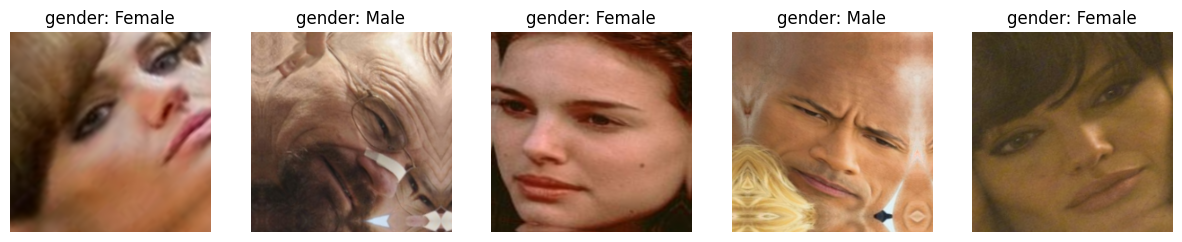

In [9]:
display_images_with_labels(train_dataset)

# Model Definition

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = True
for layer in vgg_base.layers[:-4]:
    layer.trainable = False

# custom layers
x = layers.Flatten()(vgg_base.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.002))(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation = 'relu', kernel_regularizer=l2(0.001))(x)

# output layer
gender_output = layers.Dense(1, activation='sigmoid', name='gender')(x)

gender_model = tf.keras.Model(inputs=vgg_base.input, outputs=gender_output)

# compiling the model with appropriate losses and metrics
gender_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

callback functions

In [11]:
# early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience = 5,
    min_delta = 0.001,
    restore_best_weights = True
)

# model checkpoint
checkpoint_filepath = '/content/models/gender-model-{epoch:02d}-{val_binary_accuracy:.4f}.keras'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# learning rate scheduler
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7)

In [12]:
# fitting the model
history = gender_model.fit(
    train_dataset,
    validation_data= val_dataset,
    epochs=30,
    callbacks=[early_stopping,reduce_lr, checkpoint]
)

Epoch 1/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - binary_accuracy: 0.8500 - loss: 0.9617
Epoch 1: val_binary_accuracy improved from -inf to 0.55993, saving model to /content/models/gender-model-01-0.5599.keras
719/719 ━━━━━━━━━━━━━━━━━━━━ 428s 546ms/step - binary_accuracy: 0.8501 - loss: 0.9611 - val_binary_accuracy: 0.5599 - val_loss: 1.6498 - learning_rate: 0.0010
Epoch 2/30
718/719 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - binary_accuracy: 0.9274 - loss: 0.2234
Epoch 2: val_binary_accuracy improved from 0.55993 to 0.94366, saving model to /content/models/gender-model-02-0.9437.keras
719/719 ━━━━━━━━━━━━━━━━━━━━ 385s 515ms/step - binary_accuracy: 0.9274 - loss: 0.2234 - val_binary_accuracy: 0.9437 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 3/30
718/719 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - binary_accuracy: 0.9404 - loss: 0.1832
Epoch 3: val_binary_accuracy did not improve from 0.94366
719/719 ━━━━━━━━━━━━━━━━━━━━ 384s 513ms/step - binary_accuracy: 0.9404 - loss: 0.1832 - val_bi

# Results

In [13]:
history_df = pd.DataFrame(history.history)
history_df

,binary_accuracy,loss,val_binary_accuracy,val_loss,learning_rate
0,0.895349,0.491583,0.559928,1.649763,0.0010
1,0.931996,0.208297,0.943661,0.187304,0.0010
2,0.941638,0.177690,0.849495,0.917502,0.0010
3,0.945592,0.168551,0.955864,0.138823,0.0010
4,0.949719,0.159215,0.957974,0.138012,0.0010
5,0.953238,0.144752,0.939724,0.168893,0.0010
6,0.955598,0.136348,0.956822,0.131711,0.0010
7,0.957414,0.136188,0.953754,0.152719,0.0010
8,0.958904,0.129155,0.962173,0.120685,0.0010
9,0.960318,0.127210,0.965000,0.113728,0.0010


<Axes: title={'center': 'Accuracy'}>

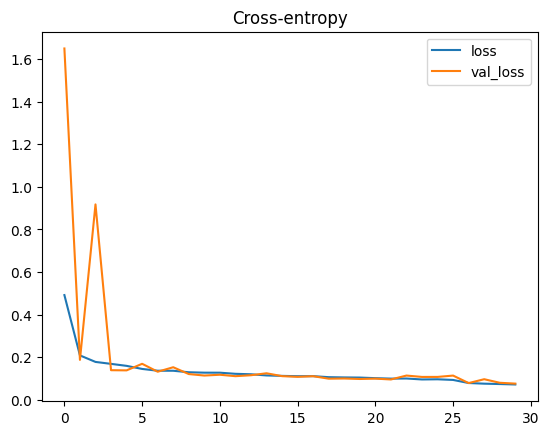

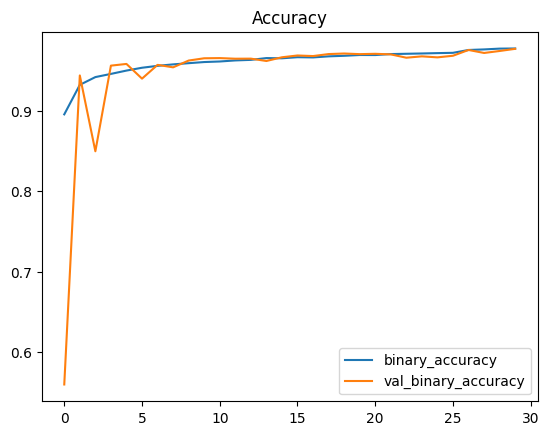

In [14]:
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
print()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [15]:
test_loss, test_accuracy = gender_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4%}")

220/220 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - binary_accuracy: 0.9736 - loss: 0.0833
Test Loss: 0.0830
Test Accuracy: 97.3274%


UTKFace

In [25]:
UTK_path = '/content/UTKFace/UTKFace'

# creating tensors
utk_img_paths, utk_labels = return_imgdata(UTK_path, 'gender')

utk_dataset = tf.data.Dataset.from_tensor_slices((utk_img_paths, utk_labels))

# preprocessing images
utk_dataset = utk_dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# batching and prefetching
utk_dataset = utk_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [26]:
test_loss, test_accuracy = gender_model.evaluate(utk_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4%}")

371/371 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - binary_accuracy: 0.8791 - loss: 0.3975
Test Loss: 0.3884
Test Accuracy: 87.8691%
